In [14]:
import pandas as pd
import networkx as nx

<h3>Graph Structure</h3>

<h4> Nodes </h4>

represent a product

Node features:
* *production* - quantifies product output considering sales orders, customer demand, vehicle fill rate, and delivery urgency.
* *sales order* - signifies distributor-requested quantities, pending approval from the accounts department.
* *delivered* - denotes products dispatched to distributors.
* *factory issue* - covers total products with issues shipped from manufacturing facilities, with some going to distributors and the rest to storage warehouses.



<h4> Edges </h4>

represent relations between products

Edge features:
* *GroupCode* :         1 or 0, if products are in the same product group
* *SubGroupCode* :      1 or 0, if products are in the same product sub-group
* *Plant* :             Number of plants in common
* *Storage Location* :  Number of Storage Locations in common

In [15]:
G = nx.Graph()

In [16]:
nodes = pd.read_csv('Raw Dataset/Homogenoeus/Nodes/Node Types (Product Group and Subgroup).csv')

nodes.head()

,Node,Group,Sub-Group
0,SOS008L02P,S,SOS
1,SOS005L04P,S,SOS
2,SOS003L04P,S,SOS
3,SOS002L09P,S,SOS
4,SOS001L12P,S,SOS


In [17]:
G.add_nodes_from(nodes['Node'])

In [18]:
def add_group_edges(path):
    """adds edges and edge features for groupcode and subgroupcode""" 
    df = pd.read_csv(path)
    edge_type = [col for col in df.columns if col[:4] != 'node'][0]
    md = [{edge_type:1} for product in df[edge_type]]
    G.add_edges_from(zip(df['node1'],df['node2'],md))

In [19]:
def add_other_edges(path):
    """adds edges and edge features for Plants and Storage Locations"""
    df = pd.read_csv(path)
    edge_type = [col for col in df.columns if col[:4] != 'node'][0]
    node1 = df['node1'].to_list()
    node2 = df['node2'].to_list()
    pairs = [set(t) for t in zip(node1,node2)]
    distinct_pairs = []
    pair_counts = []

    while len(pairs) > 0:
        p = pairs[0]
        distinct_pairs.append(p)
        n = pairs.count(p)
        pair_counts.append(n)

        for i in range(n):
            pairs.remove(p)
    
    edges = [tuple(s) + ({edge_type:pair_counts[i]},) for i,s in enumerate(distinct_pairs)]
    G.add_edges_from(edges)



In [20]:
add_other_edges('Raw Dataset/Homogenoeus/Edges/Edges (Plant).csv')
add_group_edges('Raw Dataset/Homogenoeus/Edges/Edges (Product Group).csv')
add_group_edges('Raw Dataset/Homogenoeus/Edges/Edges (Product Sub-Group).csv')
add_other_edges('Raw Dataset/Homogenoeus/Edges/Edges (Storage Location).csv')

In [21]:
#fill in attributes on edges where its missing

for node1, node2 in G.edges:
    edge_keys = G[node1][node2].keys()
    for edge_type in ['Plant','GroupCode','SubGroupCode','Storage Location']:
        if not edge_type in edge_keys:
            G[node1][node2][edge_type] = 0


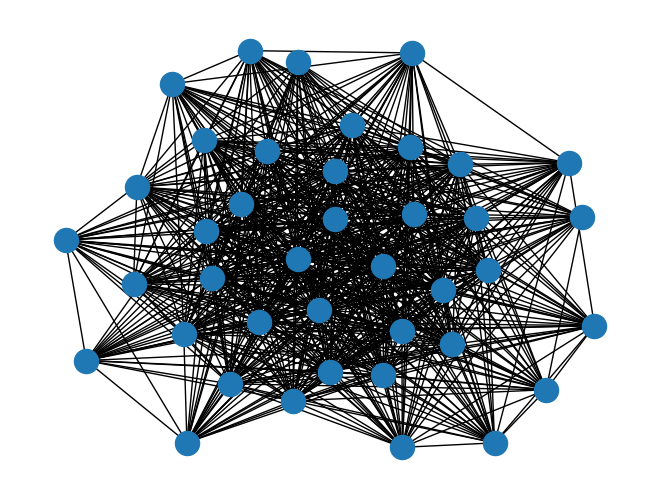

In [22]:
nx.draw(G)

In [23]:
d2d = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Unit/Delivery To distributor.csv')
fi = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Unit/Factory Issue.csv')
production = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Unit/Production .csv')
sales = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Unit/Sales Order.csv')

In [24]:
#adding temporal data as node features
for node in G.nodes: 
    G.nodes[node]['delivered'] = d2d[node].to_list()
    G.nodes[node]['factory issue'] = fi[node].to_list()
    G.nodes[node]['sales_order'] = sales[node].to_list()
    G.nodes[node]['production'] = production[node].to_list()
    G.nodes[node]['GroupCode'] = nodes[nodes['Node'] == node]['Group'].iloc[0] #feature added for exploratory purposes


In [25]:
import pickle

pickle.dump(G,open('graphs/graph.pkl','wb')) #Collab and collab pro
                                             #